Formula 1

In [12]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


In [13]:
# Config for regression
regress = True

In [ ]:
# Config for Other
regress = False

# 1 Gather Data
We want to...

In [14]:
data_dir_path = "../data/"
# Read the csv files
results = pd.read_csv(data_dir_path + "results.csv", na_values=np.nan)
driver_standings = pd.read_csv(data_dir_path + "driver_standings.csv", na_values=np.nan)
constructor_standings = pd.read_csv(
    data_dir_path + "constructor_standings.csv", na_values=np.nan
)
raceYears = pd.read_csv(data_dir_path + "races.csv", na_values=np.nan)
names = pd.read_csv(data_dir_path + "drivers.csv", na_values=np.nan)

# Filter columns
raceYears = raceYears[["raceId", "year"]]
# raceYears = raceYears[raceYears["year"] >= 2010]  # Only data after 2010
results = results[["raceId", "driverId", "constructorId", "grid", "position"]]
driver_standings = driver_standings[["raceId", "driverId", "position"]]
constructor_standings = constructor_standings[["raceId", "constructorId", "position"]]
names = names[["driverId", "driverRef"]]

# rename because other csv also have position
driver_standings = driver_standings.rename(columns={"position": "driverStanding"})
constructor_standings = constructor_standings.rename(
    columns={"position": "constructorStanding"}
)

year_driver_standing = pd.merge(raceYears, driver_standings, on=["raceId"], how="inner")

results_driver_standings = pd.merge(
    results, year_driver_standing, on=["raceId", "driverId"], how="inner"
)

joined_data = pd.merge(
    results_driver_standings,
    constructor_standings,
    on=["raceId", "constructorId"],
    how="inner",
)

joined_data = pd.merge(joined_data, names, on=["driverId"], how="inner")
joined_data.drop(columns=["raceId", "constructorId", "driverId"], inplace=True)
joined_data.replace(to_replace="\\N", value=20, inplace=True)
joined_data["position"] = joined_data["position"].astype(int)

# Drop year before calculating the mean for every driver
joined_data.drop("year", axis=1, inplace=True)

# joined_data = joined_data[joined_data["position"] <= 5]

X = joined_data[["grid", "driverStanding", "constructorStanding"]]
Y = joined_data[["position"]]


# Divide by train data and test data
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42, shuffle=True
)


In [15]:
def edit_Y(y, regression=True):
    """Edits Y to be 1 or not 1 for regression or not regression.

    Notes:
        Pandas DF is passed by reference, so no returns.

    Args:
        y (pd.DataFrame): Dataframe with column position
        regression (bool, optional): True if regression, false for others.
    """
    y.loc[(y["position"] != 1) & (y["position"] != 2) & (y["position"] != 3)] = (
        0 if regression else -1
    )
    # y.loc[(y["position"] == 2) | (y["position"] == 3)] = 1

In [16]:
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

edit_Y(Y_train, regression=regress)
edit_Y(Y_test, regression=regress)

Y_train = Y_train.to_numpy()
Y_test = Y_test.to_numpy()

Y_train = Y_train.reshape(Y_train.shape[0])
Y_test = Y_test.reshape(Y_test.shape[0])


# 2 Standardise and Scale

In [17]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 3 Plotting Functions

In [18]:
def plot_error(training_error, testing_error):
    """Plots the training and testing error.

    Args:
        training_error (list): List of training errors
        testing_error (list): List of testing errors
    """
    plt.plot(training_error, label="Training Error")
    plt.plot(testing_error, label="Testing Error")
    plt.xticks(np.arange(len(testing_error)), np.arange(1, len(testing_error) + 1))
    plt.xlabel("Degree")
    plt.ylabel("Error")
    plt.legend()
    plt.show()


def plot_accuracy(training_acc, testing_acc):
    """Plots the training and testing error.

    Args:
        training_error (list): List of training errors
        testing_error (list): List of testing errors
    """
    plt.plot(training_acc, label="Training Accuracy")
    plt.plot(testing_acc, label="Testing Accuracy")
    plt.xticks(np.arange(len(testing_acc)), np.arange(1, len(testing_acc) + 1))
    plt.xlabel("Degree")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()


def plot(training_error, testing_error, training_acc, testing_acc):
    plot_error(training_error, testing_error)
    plot_accuracy(training_acc, testing_acc)


# 4A Logistic Regression

In [19]:
def polynomial_logistic_regression(X_train, Y_train, X_test, Y_test, max_degree=6):
    """Polynomial logistic regression

    Args:
        X_train (np.array): Training data
        Y_train (np.array): Training labels
        X_test (np.array): Testing data
        Y_test (np.array): Testing labels
    """
    logreg = LogisticRegression(multi_class="multinomial", max_iter=10_000)
    training_error, testing_error = [], []
    training_acc, testing_acc = [], []

    print("Polynomial Logistic Regression Score")
    print("Degree \t Test Score \t Train Score")
    for i in range(1, max_degree + 1):
        # Init polynomial features
        poly = PolynomialFeatures(degree=i)

        # Polynomial fit of training data
        X_train_poly = poly.fit_transform(X_train)

        # Train model
        logreg.fit(X_train_poly, Y_train)

        # Polynomial fit of test data
        X_test_poly = poly.fit_transform(X_test)

        # Get scores
        training_score = logreg.score(X_train_poly, Y_train)
        testing_score = logreg.score(X_test_poly, Y_test)

        # Append accuracy
        training_acc.append(training_score)
        testing_acc.append(testing_score)

        # Append errors
        training_error.append(1 - training_score)
        testing_error.append(1 - testing_score)

        # Fancy print B)
        print(f"{i} \t {testing_score*100.0:.2f}% \t {training_score*100.0:.2f}%")

    return training_error, testing_error, training_acc, testing_acc


In [9]:
(
    training_error,
    testing_error,
    training_acc,
    testing_acc,
) = polynomial_logistic_regression(X_train, Y_train, X_test, Y_test, max_degree=7)

3 	 88.84% 	 88.36%
4 	 88.73% 	 88.40%
5 	 88.69% 	 88.42%
6 	 88.57% 	 88.44%
7 	 88.50% 	 88.58%


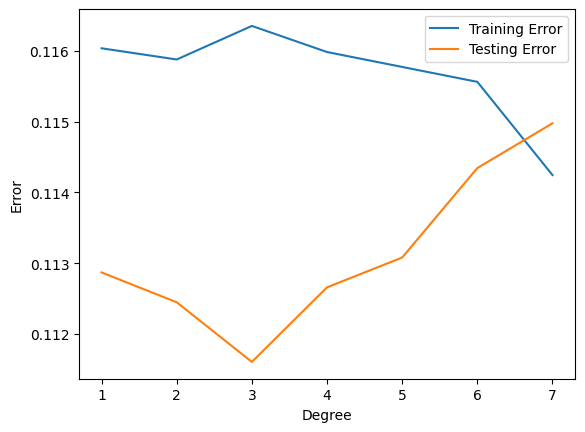

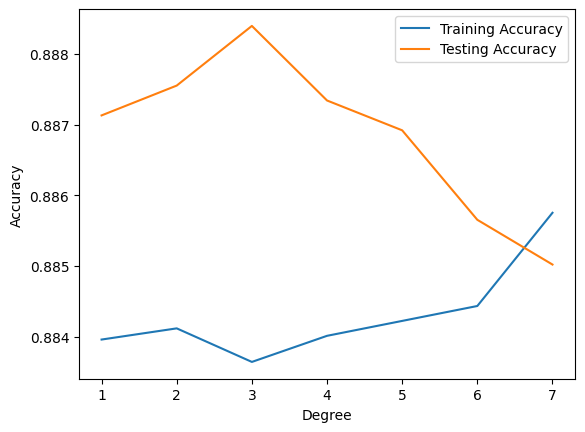

In [10]:
plot(training_error, testing_error, training_acc, testing_acc)


# 4B SVM

In [ ]:
# svmachine = SVC(kernel='rbf', C=1E6)
# svmachine.fit(X_train, Y_train)
# svmachine.score(X_train, Y_train)

In [ ]:
def polynomial_svm(X_train, Y_train, X_test, Y_test, max_degree=6):
    """Polynomial Support Vector Machine

    Args:
        X_train (np.array): Training data
        Y_train (np.array): Training labels
        X_test (np.array): Testing data
        Y_test (np.array): Testing labels
    """
    training_error, testing_error = [], []
    training_acc, testing_acc = [], []

    print("Polynomial SVM Score")
    print("Degree \t Test Score \t Train Score")
    for i in range(1, max_degree + 1):
        svmachine = SVC(kernel="linear")

        # Init polynomial features
        poly = PolynomialFeatures(degree=i)

        # # Polynomial fit of training data
        X_train_poly = poly.fit_transform(X_train)
        X_test_poly = poly.fit_transform(X_test)

        svmachine.fit(X_train_poly, Y_train)
        # Get scores
        training_score = svmachine.score(X_train_poly, Y_train)
        testing_score = svmachine.score(X_test_poly, Y_test)

        # Append accuracy
        training_acc.append(training_score)
        testing_acc.append(testing_score)

        # Append errors
        training_error.append(1 - training_score)
        testing_error.append(1 - testing_score)

        # Fancy print B)
        print(f"{i} \t {testing_score*100.0:.2f}% \t {training_score*100.0:.2f}%")

    return training_error, testing_error, training_acc, testing_acc


In [ ]:
training_error, testing_error, training_acc, testing_acc = polynomial_svm(
    X_train, Y_train, X_test, Y_test, max_degree=5
)


In [ ]:
plot(training_error, testing_error, training_acc, testing_acc)


# 4C Neural Network

In [11]:
# Define the model architecture
model = Sequential(
    [
        Dense(32, activation="tanh", input_shape=(3,)),
        Dense(16, activation="elu"),
        Dense(4, activation="softmax"),
    ]
)

# Compile the model with an optimizer, loss function, and metrics
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

Y_train_one_hot = tf.one_hot(Y_train - 1, depth=4)
Y_test_one_hot = tf.one_hot(Y_test - 1, depth=4)

# Train the model on the training data
model.fit(
    X_train,
    Y_train_one_hot,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, Y_test_one_hot),
)

# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test, Y_test_one_hot)
print(f"Test loss: {loss*100:.2f}% \t Test accuracy: {accuracy*100:.2f}%")

Epoch 1/100
593/593 [==============================] - 1s 1ms/step - loss: 0.1676 - accuracy: 0.8560 - val_loss: 0.1546 - val_accuracy: 0.9173
Epoch 2/100
593/593 [==============================] - 1s 1ms/step - loss: 0.1586 - accuracy: 0.9139 - val_loss: 0.1484 - val_accuracy: 0.9173
Epoch 3/100
593/593 [==============================] - 1s 1ms/step - loss: 0.1570 - accuracy: 0.9139 - val_loss: 0.1536 - val_accuracy: 0.9173
Epoch 4/100
593/593 [==============================] - 1s 1ms/step - loss: 0.1559 - accuracy: 0.9139 - val_loss: 0.1499 - val_accuracy: 0.9173
Epoch 5/100
593/593 [==============================] - 1s 1ms/step - loss: 0.1556 - accuracy: 0.9139 - val_loss: 0.1489 - val_accuracy: 0.9173
Epoch 6/100
593/593 [==============================] - 1s 1ms/step - loss: 0.1546 - accuracy: 0.9139 - val_loss: 0.1500 - val_accuracy: 0.9173
Epoch 7/100
593/593 [==============================] - 1s 1ms/step - loss: 0.1548 - accuracy: 0.9139 - val_loss: 0.1520 - val_accuracy: 0.9173